### K562 overexpression example

This notebook prepares a dataset from a tech-dev paper with a gazillion Perturb-seq experiments applied to mostly K562 ([Replogle et al 2020](https://www.nature.com/articles/s41587-020-0470-y)). We'll focus on just the CRISPRa multiplexing experiment, which does overexpression. 

Here we tidy the dataset and carry out a simple exploration in scanpy.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML
# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

import anndata
import os, sys
import itertools as it
from scipy.stats import spearmanr, pearsonr, rankdata, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


#      visualization settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# I prefer to specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbation_data")

# Universal
geneAnnotationPath = "../accessory_data/gencode.v35.annotation.gtf.gz"       # Downloaded from https://www.gencodegenes.org/human/release_35.html
humanTFPath =  "../accessory_data/humanTFs.csv"                              # Downloaded from http://humantfs.ccbr.utoronto.ca/download.php
humanEpiPath = "../accessory_data/epiList.csv"                               # Downloaded from https://epifactors.autosome.org/description 
cellcycleGenePath = "../accessory_data/regev_lab_cell_cycle_genes.txt"

# Replogle1 Specific
dataset_name = "replogle"
perturbEffectTFOnlyPath = "setup/replogle1TFOnly.csv"                         # a path to store temp file
perturbEffectFullTranscriptomePath = "setup/replogle1FullTranscriptome.csv"   # a path to store temp file

### How many TF's are perturbed?

In [2]:
human_tfs = pd.read_csv(humanTFPath)
EpiList   = pd.read_csv(humanEpiPath, index_col=0).iloc[:, [0,14]]
human_tfs = human_tfs.loc[human_tfs["Is TF?"]=="Yes",:]
replogle_perturbations = pd.read_csv(f"not_ready/{dataset_name}/perturbed_genes.csv")
replogle_perturbations.drop_duplicates(inplace = True)
replogle_perturbations["is_tf"] = replogle_perturbations["gene"].isin(human_tfs["HGNC symbol"]) # | replogle_perturbations["gene"].isin(EpiList["HGNC_symbol"]) 
display(replogle_perturbations.groupby("experiment").count()) #total
display(replogle_perturbations.groupby("experiment").sum()) #tf only
replogle_perturbations.query("experiment=='CRISPRa multiplex'")["gene"].unique() #which TF's

gene  is_tf
experiment                    
CRISPRa multiplex    63     63
CRISPRi multiplex   104    104
IPSC                 19     19
Interaction          41     42
UPR validation       30     30

is_tf
experiment              
CRISPRa multiplex     33
CRISPRi multiplex      9
IPSC                   5
Interaction            2
UPR validation         0

array(['CDKN1A', 'CDKN1B', 'CEBPB', 'CERKL', 'COL2A1', 'EOMES', 'ETS2',
       'FOXC1', 'HHEX', 'HIC2', 'HOXD13', 'IGDCC3', 'IRF1', 'KLF1',
       'LHX4', 'MAP2K3', 'MAP2K6', 'MAPK1', 'MEIS2', 'NEUROD1', 'NPM1',
       'PRTG', 'PTPN1', 'SET', 'SPI1', 'TIPARP', 'TLE3', 'TTC6', 'ZNF296',
       'AIRE', 'ASCL1', 'ATF4', 'ATF5', 'BACH2', 'CCDC51', 'COX5A',
       'CREB1', 'DDIT3', 'DDIT4', 'EIF2S1', 'FOXP3', 'GATA3', 'HIF1A',
       'HSF1', 'HSPA9', 'HSPD1', 'MTOR', 'NEUROG2', 'NRF1', 'PISD',
       'PPARGC1A', 'RANBP1', 'RORA', 'RPL30', 'RPS18', 'SREBF1', 'TBX21',
       'TFAP4', 'TIMM50', 'TMA7', 'UPF1', 'ZNF236', 'ZNF574'],
      dtype=object)

### Load expression data & set up cell metadata

In [3]:
# Reading from .mtx is slow, so we memoize to h5ad. 
if not os.path.exists(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip"):
    expression_quantified = sc.read_10x_mtx(f"not_ready/{dataset_name}/GSM4367986_exp8/")
    expression_quantified.write_h5ad(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip", compression="gzip")
else:
    expression_quantified = sc.read_h5ad(f"not_ready/{dataset_name}/GSM4367986_exp8/overall.h5ad.gzip")

In [4]:
sc.pp.calculate_qc_metrics(expression_quantified, inplace = True)
cell_metadata = pd.read_csv(f"not_ready/{dataset_name}/GSM4367986_exp8/cell_identities.csv.gz")
cell_metadata.index = cell_metadata["cell_barcode"]
cell_metadata["target_symbol"] = ingestion.convert_ens_to_symbol(
    cell_metadata["target"], 
    gtf=geneAnnotationPath, 
    strip_version = True)
cell_metadata["target_is_tf"] = cell_metadata["target_symbol"].isin(human_tfs["HGNC symbol"]).astype("int")
expression_quantified.obs = pd.merge(expression_quantified.obs,
                                     cell_metadata, 
                                     how = "left", 
                                     left_index = True, 
                                     right_index = True)

expression_quantified.obs["has_guide_annotations"] = pd.notnull(expression_quantified.obs["coverage"]).astype("int")
expression_quantified.obs["good_coverage"] = expression_quantified.obs["good_coverage"].astype("str")
expression_quantified.raw = expression_quantified.copy()

In [5]:
expression_quantified = expression_quantified[~expression_quantified.obs.target_symbol.isna(), :]

### How many cells do we have for each target?

target_symbol  n_cells  is_tf
0           CEBPB      212   True
1            LHX4      238   True
2           PTPN1      284  False
3          CDKN1B      303  False
4           TBX21      315   True
..            ...      ...    ...
59           TTC6     1513  False
60          RPL30     1712  False
61           MTOR     1735  False
62         MAP2K3     1861  False
63  Non-Targeting     5126  False

[64 rows x 3 columns]

Text(0.5, 1.0, 'CRISPRa in K562')

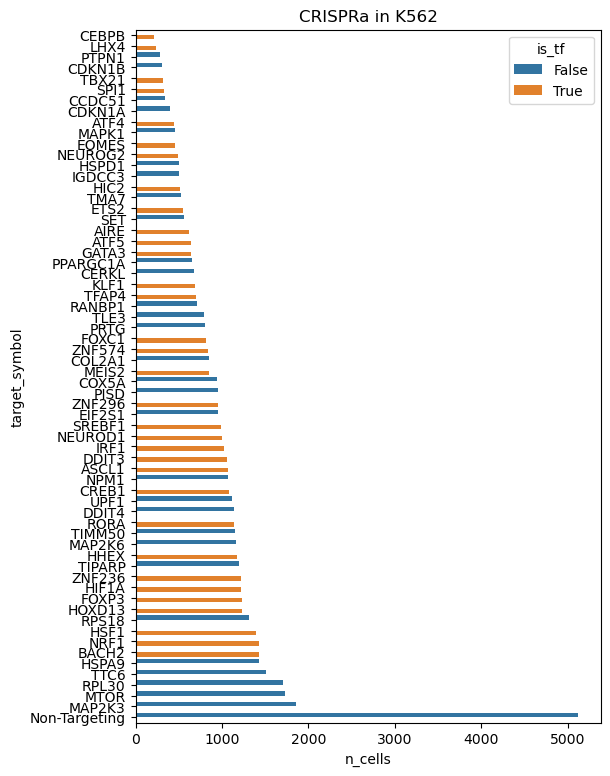

In [6]:
n_cells_per_target = expression_quantified.obs.groupby("target_symbol")[["cell_barcode"]].count().sort_values("cell_barcode")
n_cells_per_target.columns = ["n_cells"]
n_cells_per_target["is_tf"] = n_cells_per_target.index.isin(human_tfs["HGNC symbol"])
n_cells_per_target.reset_index(inplace = True)
display(n_cells_per_target)
plt.rcParams['figure.figsize'] = [6, 9]
sns.barplot(data = n_cells_per_target, x = "n_cells", y = "target_symbol", hue = "is_tf").set_title("CRISPRa in K562")

### Convert ensembl gene id's to gene symbol

In [7]:
expression_quantified.var_names = ingestion.convert_ens_to_symbol(
    expression_quantified.var_names, 
    gtf=geneAnnotationPath, 
)
display(expression_quantified.var.head())
display(expression_quantified.var_names[0:5])

gene_ids    feature_types  n_cells_by_counts  \
RP11-34P13.3  ENSG00000243485  Gene Expression                 14   
FAM138A       ENSG00000237613  Gene Expression                  0   
OR4F5         ENSG00000186092  Gene Expression                  0   
RP11-34P13.7  ENSG00000238009  Gene Expression                343   
RP11-34P13.8  ENSG00000239945  Gene Expression                 55   

              mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
RP11-34P13.3     0.000127           0.000127              99.987326   
FAM138A          0.000000           0.000000             100.000000   
OR4F5            0.000000           0.000000             100.000000   
RP11-34P13.7     0.003105           0.003100              99.689486   
RP11-34P13.8     0.000498           0.000498              99.950209   

              total_counts  log1p_total_counts  
RP11-34P13.3          14.0            2.708050  
FAM138A                0.0            0.000000  
OR4F5                  0.0            0.000000  
RP11-34P13.7         343.0            5.840641  
RP11-34P13.8          55.0            4.025352

Index(['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8'], dtype='object')

### Fill `perturbation` & `Is_control`

In [8]:
controls = ["Non-Targeting"]
expression_quantified.obs["perturbation"]     = expression_quantified.obs['target_symbol']
expression_quantified.obs["is_control"]       = expression_quantified.obs['target_symbol'].isin(controls)
expression_quantified.obs["is_control_int"]   = expression_quantified.obs['target_symbol'].isin(controls).astype(int)

In [9]:
expression_quantified

AnnData object with n_obs × n_vars = 60725 × 33694
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'cell_barcode', 'guide_identity', 'num_guides', 'gene', 'best_gamma', 'correction', 'distance', 'gamma_A', 'gamma_B', 'gene_type', 'protospacer_A', 'protospacer_B', 'rank_A', 'rank_B', 'sgID_A', 'sgID_B', 'type', 'target', 'umi_A', 'umi_B', 'read_count', 'UMI_count', 'coverage', 'good_coverage', 'number_of_cells', 'gemgroup', 'target_symbol', 'target_is_tf', 'has_guide_annotations', 'perturbation', 'is_control', 'is_control_int'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Single-cell RNA standard filters

We prefer to err on the side of discarding real cells rather than risking inclusion of empty droplets, doublets, or other artifacts in our analysis. Out of an abundance of caution, we remove droplets with especially high or low total counts, and we remove droplets with high fractions of RNA from mitochondrial RNA's, ribosomal protein subunit RNA's, or high-expressed RNA's. With apologies, please RTFS below for exact thresholds and numbers. 

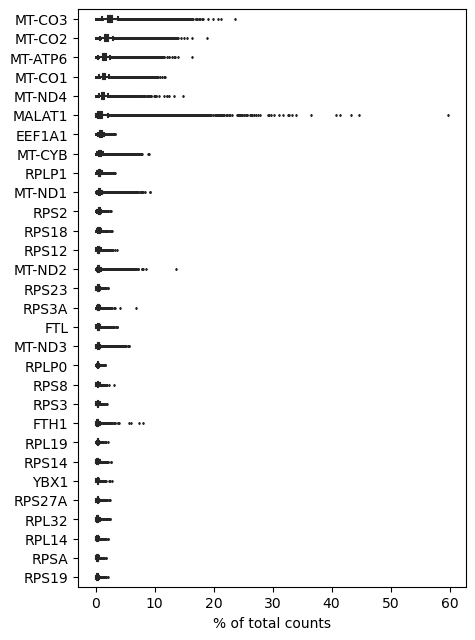

In [10]:
sc.pl.highest_expr_genes(expression_quantified, n_top=30, palette="Blues", width=.3)

In [11]:
expression_quantified.var['mt']   = expression_quantified.var_names.str.startswith(("MT-"))
expression_quantified.var['ribo'] = expression_quantified.var_names.str.startswith(("RPS","RPL"))
expression_quantified.var['mt'].sum(), expression_quantified.var['ribo'].sum(), 

(13, 103)

In [12]:
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

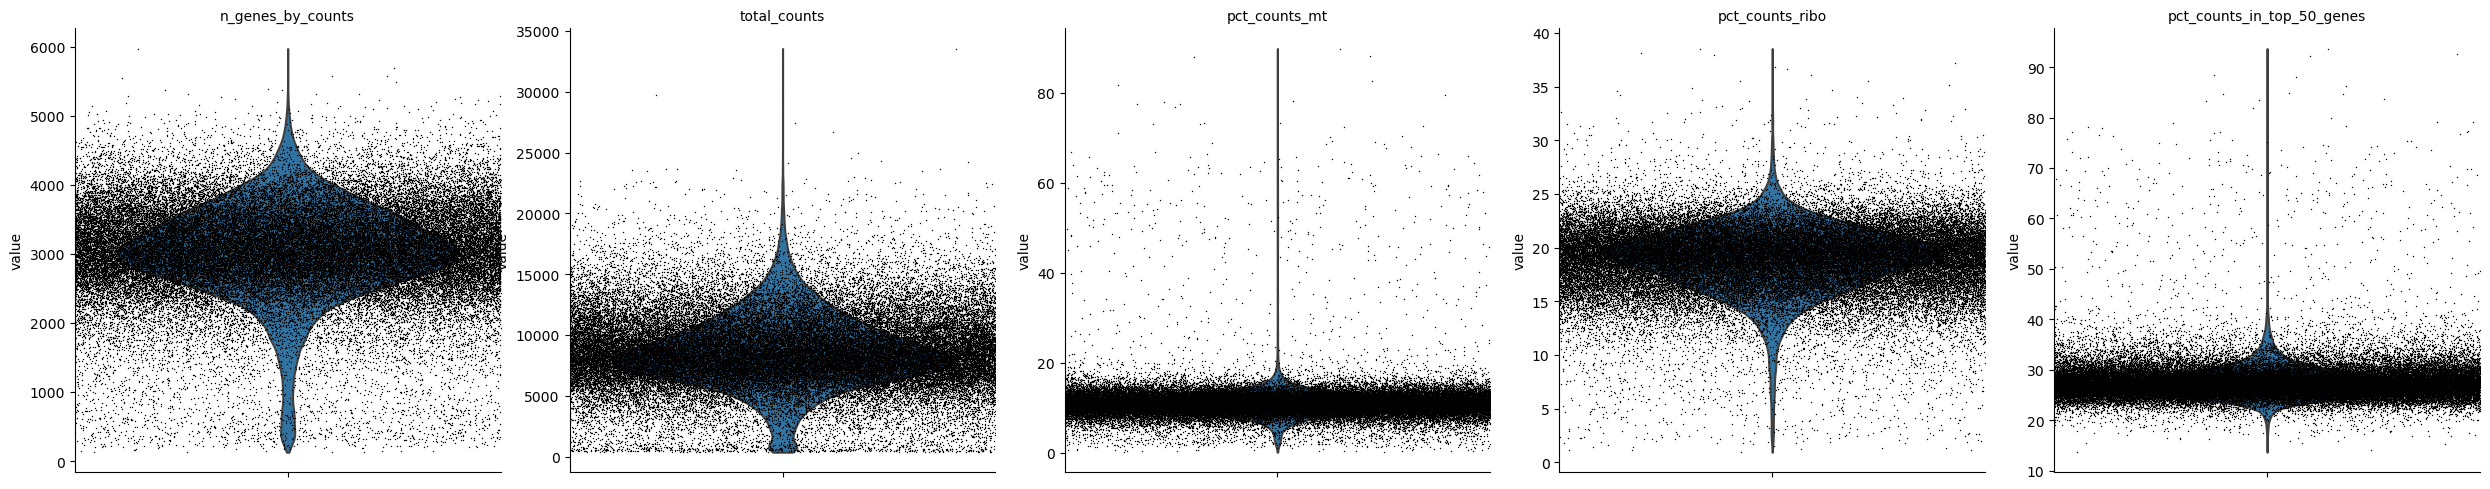

In [13]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.5, multi_panel=True)

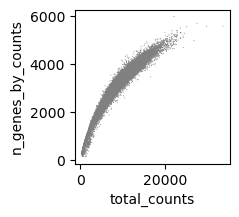

In [14]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

In [15]:
print("Number of cells: ", expression_quantified.n_obs)

# figure out the total counts == 95 percentile
thresh = np.percentile(expression_quantified.obs['total_counts'], 99)
print("99th percentile: ", thresh)

Number of cells:  60725
99th percentile:  17000.280000000006


In [16]:
expression_quantified = expression_quantified[expression_quantified.obs['total_counts'] < thresh, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  60117


In [17]:
expression_quantified = expression_quantified[expression_quantified.obs["total_counts"] >= 2000, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58809


In [18]:
expression_quantified = expression_quantified[expression_quantified.obs["pct_counts_in_top_50_genes"] <= 40, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58589


In [19]:
# filter for % mt
expression_quantified = expression_quantified[expression_quantified.obs['pct_counts_mt'] < 20, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58484


In [20]:
# filter for % ribo > 50%
expression_quantified = expression_quantified[expression_quantified.obs['pct_counts_ribo'] < 30, :].copy()
print("Number of cells: ", expression_quantified.n_obs)

Number of cells:  58415


In [21]:
""" To verify the outcome of filtering cells """
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

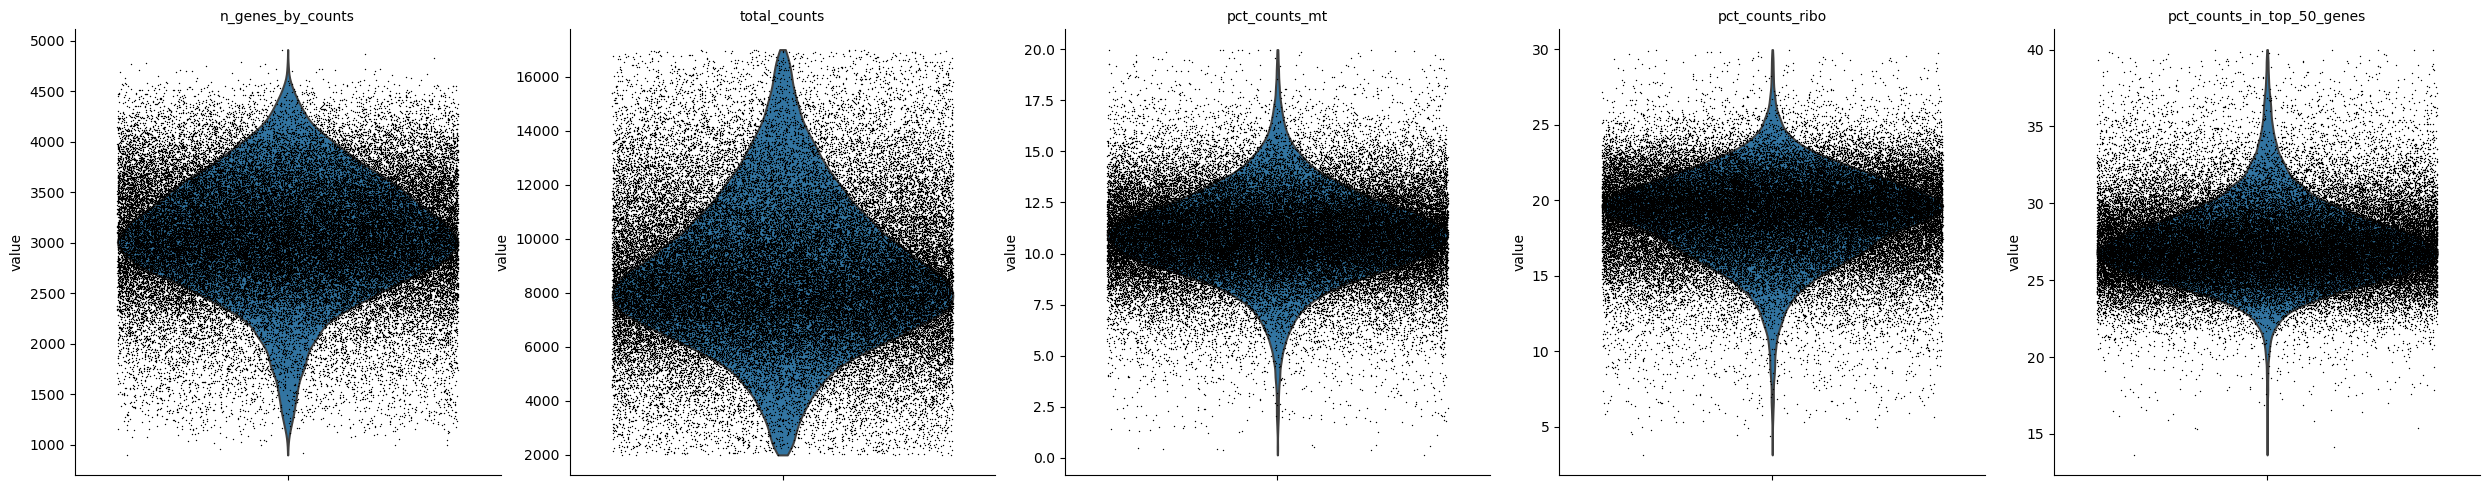

In [22]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.4, multi_panel=True)

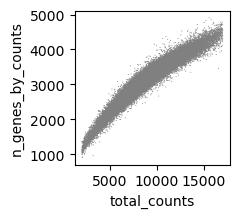

In [23]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

In [24]:
print("Number of genes: ", expression_quantified.n_vars)
gThresh = 10

sc.pp.filter_genes(expression_quantified, min_cells=gThresh)
print("Number of genes: ", expression_quantified.n_vars)

Number of genes:  33694
Number of genes:  18811


In [25]:
""" Specifically rescuing the perturbed genes """
rows = [np.where(expression_quantified.var_names == p)[0] 
        for p in set(expression_quantified.obs.perturbation) 
        if p in expression_quantified.var_names]
perturbedKeep = np.full(expression_quantified.n_vars, False)
perturbedKeep[rows] = True
np.sum(perturbedKeep)

61

In [26]:
mito_genes = expression_quantified.var_names.str.startswith('MT-')
ribo_genes = expression_quantified.var_names.str.startswith(("RPL","RPS"))
malat_gene = expression_quantified.var_names.str.startswith("MALAT1")

In [27]:
remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, malat_gene)
keep = np.invert(remove)
keep = keep | perturbedKeep
expression_quantified = expression_quantified[:,keep].copy()
print("Number of genes: ", expression_quantified.n_vars)

Number of genes:  18702


In [28]:
[idx for idx, n in enumerate(expression_quantified.var.index) if n.upper() == 'GAPDH']

[11182]

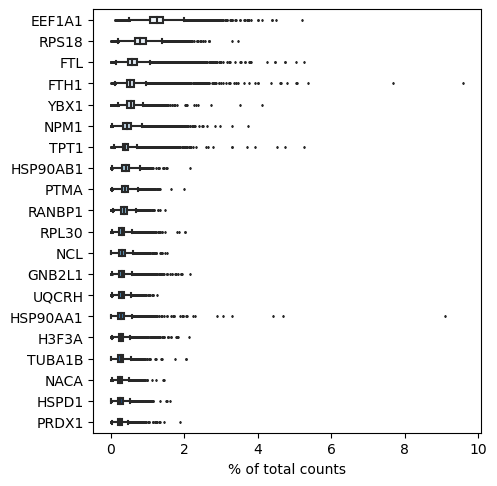

In [29]:
sc.pl.highest_expr_genes(expression_quantified, n_top=20, palette="Blues", width=.3)

In [30]:
""" To verify the outcome of filtering genes """
sc.pp.calculate_qc_metrics(expression_quantified, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

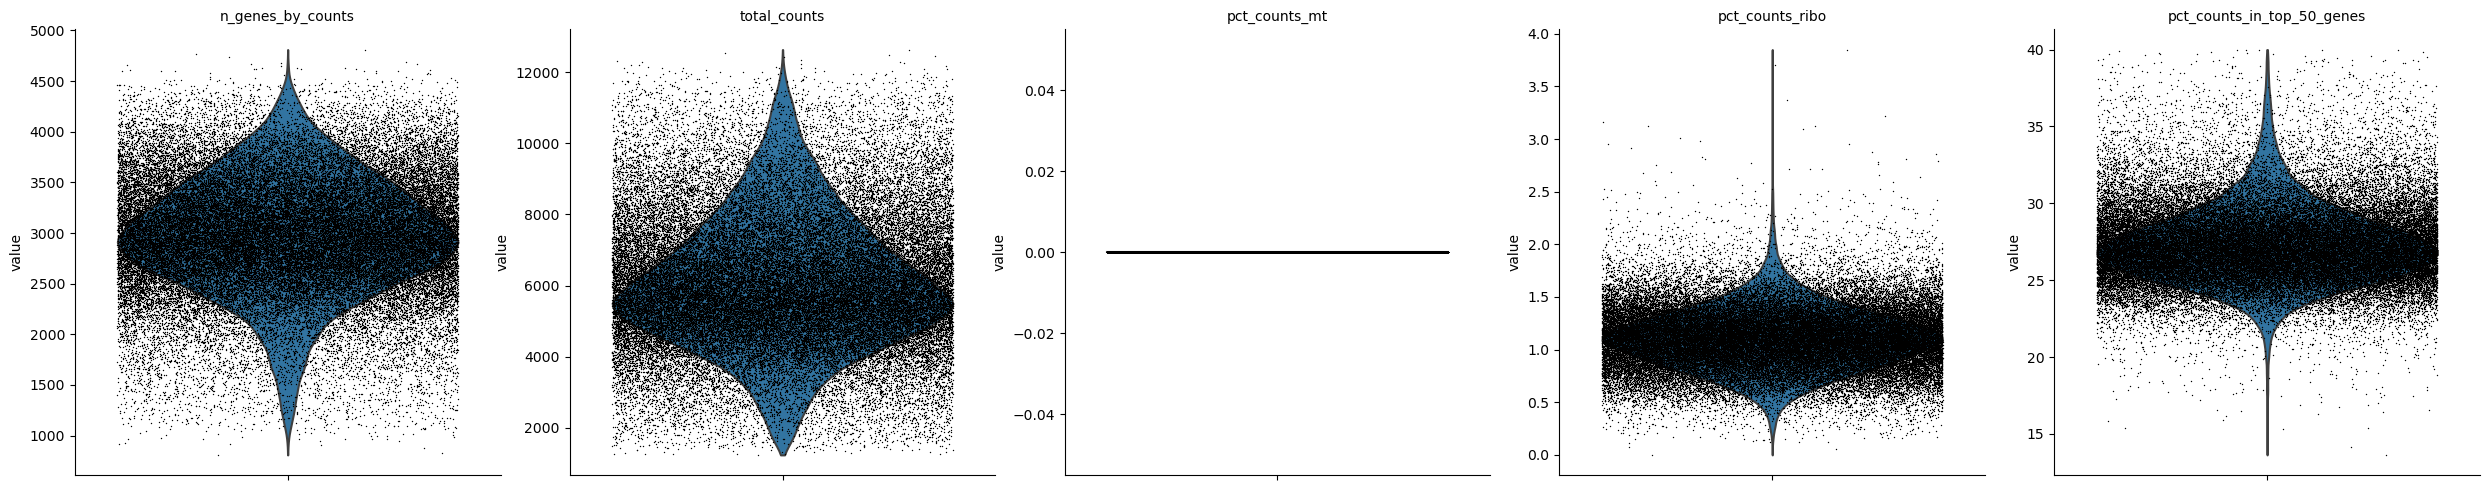

In [31]:
axs = sc.pl.violin(expression_quantified, ['n_genes_by_counts', 
                                           'total_counts', 
                                           'pct_counts_mt', 
                                           'pct_counts_ribo', 
                                           'pct_counts_in_top_50_genes'], 
                   jitter=0.4, multi_panel=True)

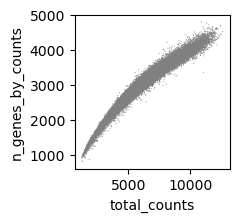

In [32]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
sc.pl.scatter(expression_quantified, x='total_counts', y='n_genes_by_counts', ax=ax)

### Basic EDA 

We supply some basic exploratory plots.

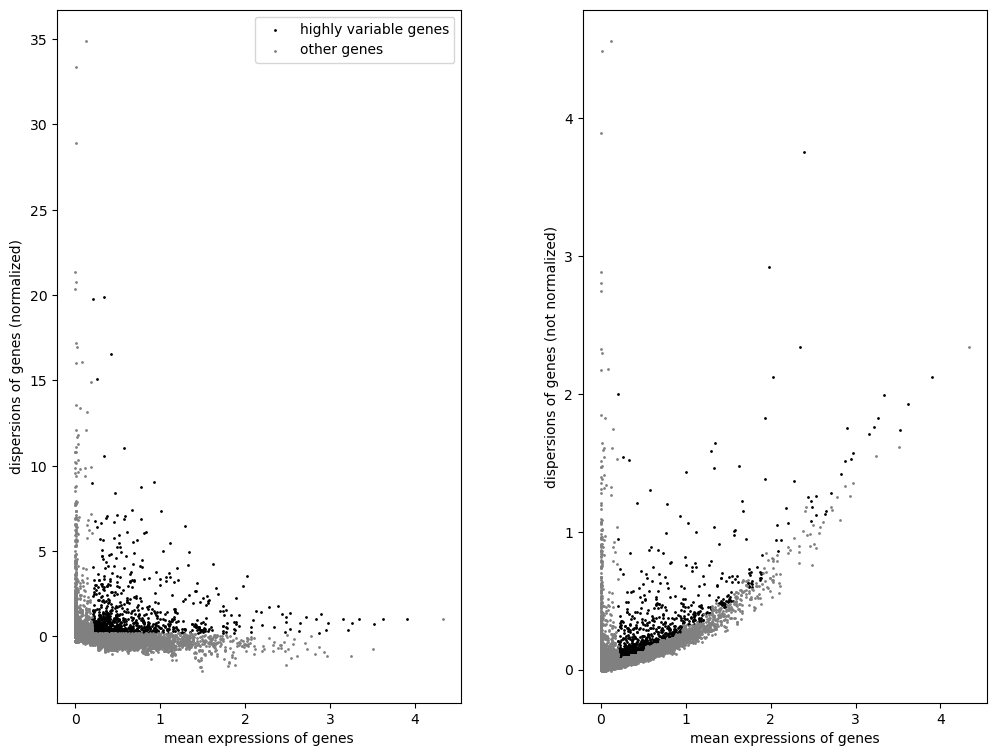

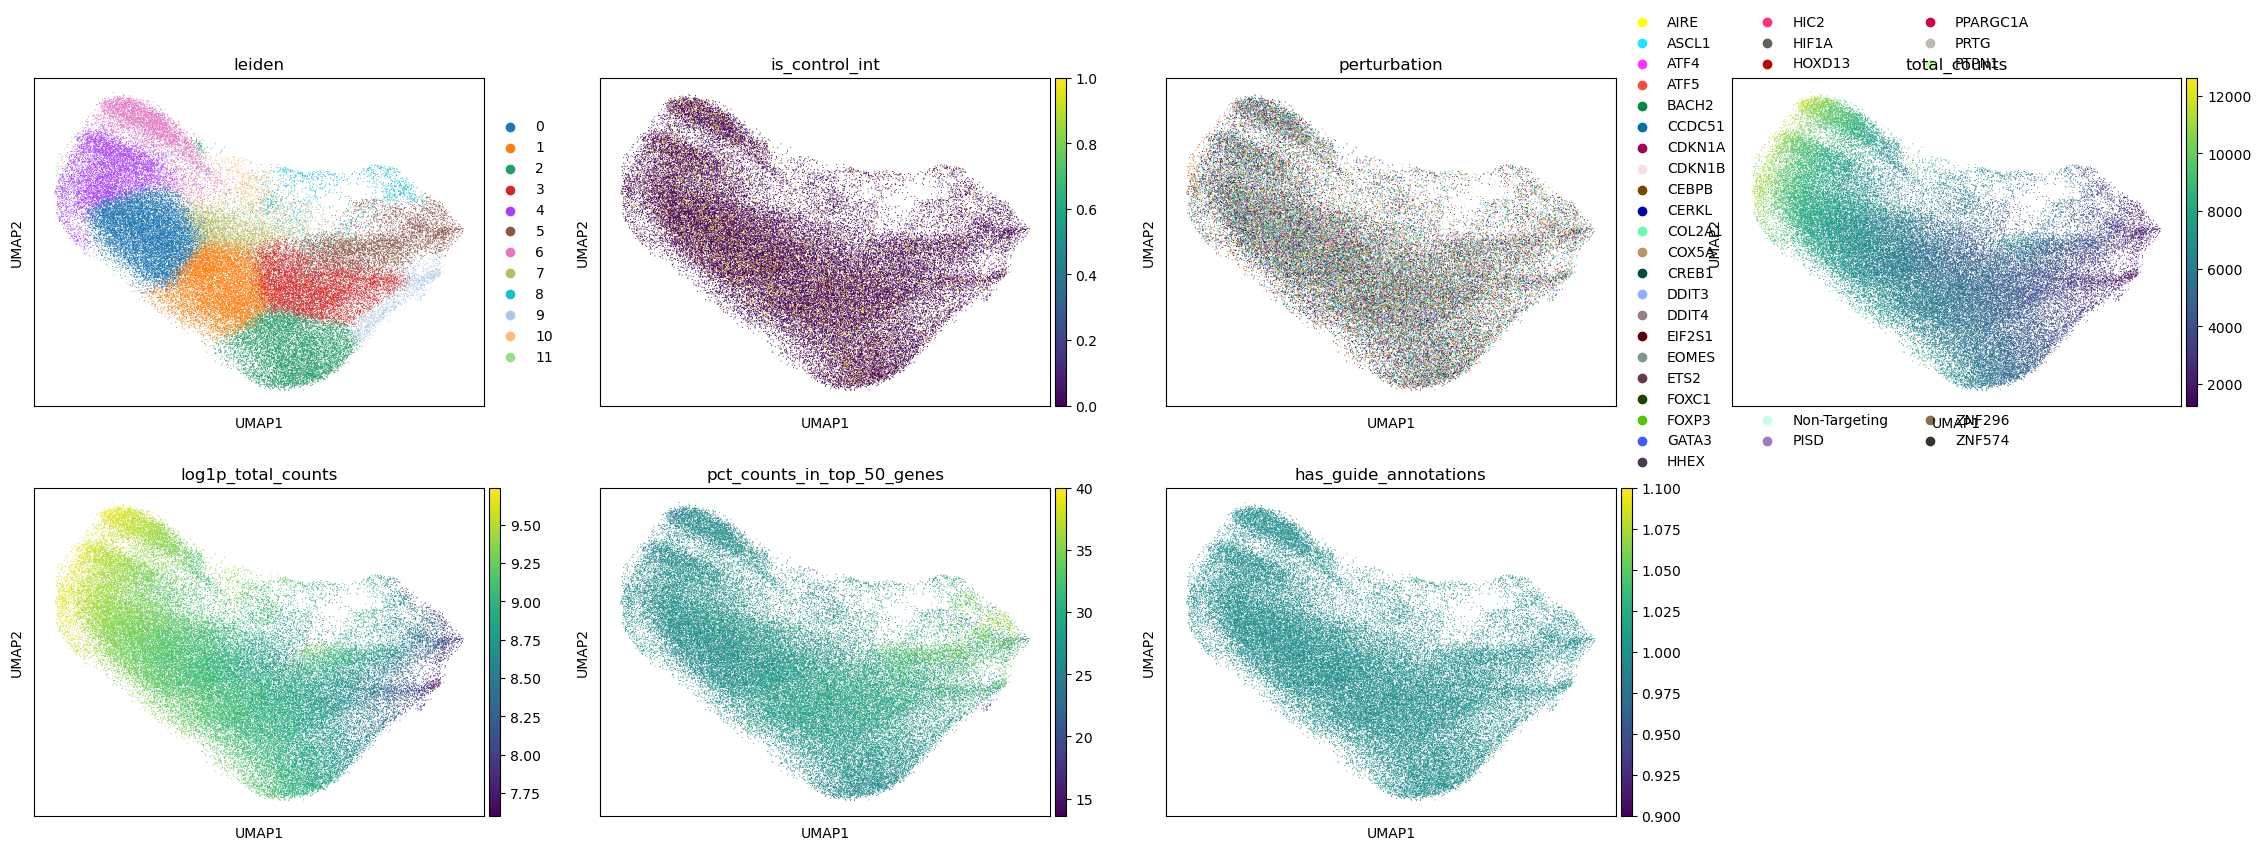

In [33]:
# When we do pseudo-bulk aggregation, we will want "raw" counts (not normalized), 
# but after applying the above filters. So we re-save the .raw attribute now.
expression_quantified.raw = expression_quantified.copy()
sc.pp.log1p(expression_quantified)
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=100)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)
cc_genes = pd.read_csv(cellcycleGenePath, header = None)[0]
sc.tl.score_genes_cell_cycle(expression_quantified, s_genes=cc_genes[:43], g2m_genes=cc_genes[43:])
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(expression_quantified, color = [
    # "PTPRC",
    "leiden", 
    "is_control_int",
    "perturbation",
    'total_counts', 
    'log1p_total_counts',
    'pct_counts_in_top_50_genes', 
    'has_guide_annotations',
])
# Will ask CellOracle to use only one cluster.
# This requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"]="all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Aggregate For Pseudo-Bulk

In [34]:
def aggregate(adata: anndata.AnnData):
    ad1 = adata.copy()
    
    uniqueGroup = np.array([f"{i}*{j}" for i,j in zip(ad1.obs.target_symbol, ad1.obs.type)])
    rowIndex    = np.array([uniqueGroup == i for i in set(sorted(uniqueGroup))])
    print(np.median([sum(r) for r in rowIndex]))
    newX        = np.squeeze([np.sum(ad1.raw.X[r,:], axis=0) for r in rowIndex])
    newPerturb  = np.array([i.split("*")[0] for i in set(sorted(uniqueGroup))])
    newGuideRNA = np.array([i.split("*")[1] for i in set(sorted(uniqueGroup))])
    newControl  = np.array([True if 'Non-Targeting' in i else False for i in set(sorted(uniqueGroup))], dtype=bool)
    newControlInt  = np.array([1 if 'Non-Targeting' in i else 0 for i in set(sorted(uniqueGroup))], dtype=int)
    newObsMeta  = pd.DataFrame()
    newObsMeta['is_control']     = newControl
    newObsMeta['is_control_int'] = newControlInt
    newObsMeta['perturbation']   = newPerturb
    newObsMeta['guideRNA']       = newGuideRNA
    newAdata    = sc.AnnData(newX, 
                             var=ad1.var.copy(),
                             obs=newObsMeta)
    return newAdata
    
pseudobulk = aggregate(expression_quantified)

220.5


In [35]:
rows = [np.where(expression_quantified.var_names == p)[0] 
        for p in set(expression_quantified.obs.perturbation) 
        if p in expression_quantified.var_names]
perturbedKeep = np.full(expression_quantified.n_vars, False)
perturbedKeep[rows] = True
print(f"{np.sum(perturbedKeep)} columns to keep (perturbed genes)")
retainColumn = np.max(pseudobulk.X[~pseudobulk.obs.is_control], axis=0) > 100
retainColumn = retainColumn | perturbedKeep
pseudobulk = pseudobulk[:, retainColumn].copy()
print(f"{pseudobulk.shape} is post-filtering shape.")

61 columns to keep (perturbed genes)
(254, 6651) is post-filtering shape.


### Normalization on pseudobulk

In [36]:
pseudobulk.raw = pseudobulk

In [37]:
pseudobulk.X = ingestion.deseq2Normalization(pseudobulk.X.T).T

### Visualize Normalization Effort

In [38]:
z2 = pseudobulk.copy()

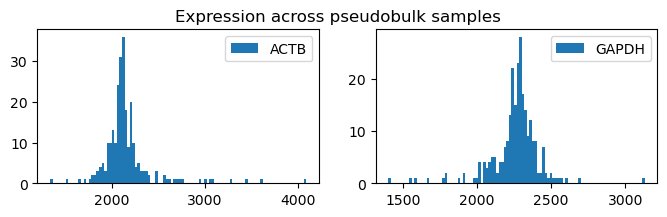

In [39]:
""" Sanity check: expression for house keeping genes are relatively stable """
fig, axes = plt.subplots(1, 2, figsize=(8,2))
axes[0].hist(z2.X[:, [idx for idx, n in enumerate(pseudobulk.var.index) if n.upper() == 'ACTB']], bins=100, label="ACTB")
axes[1].hist(z2.X[:, [idx for idx, n in enumerate(pseudobulk.var.index) if n.upper() == 'GAPDH']], bins=100, label="GAPDH")
axes[0].legend()
axes[1].legend()
plt.suptitle("Expression across pseudobulk samples")
plt.show()

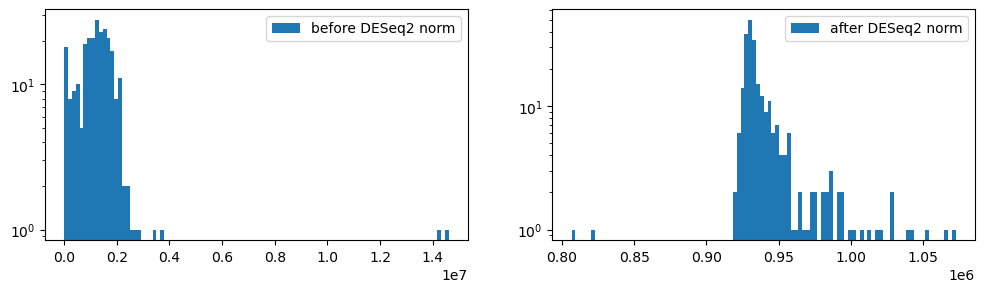

In [40]:
""" The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].hist(pseudobulk.raw.X.sum(axis=1), bins=100, log=True, label="before DESeq2 norm")
axes[1].hist(pseudobulk    .X.sum(axis=1), bins=100, log=True, label= "after DESeq2 norm")
axes[0].legend()
axes[1].legend()
plt.show()

### Check Consistency between perturbation and measured

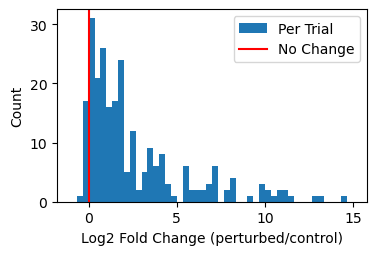

Counter({'Yes': 225, 'No': 21, 'NA': 8})

In [42]:
# If verbose is set to True, display disconcordant trials and their controls
status, logFC = ingestion.checkConsistency(pseudobulk, 
                                           perturbationType="overexpression", 
                                           group=None,
                                           verbose=False) 
pseudobulk.obs["consistentW/Perturbation"] = status
pseudobulk.obs["logFC"] = logFC
Counter(status)

### Final decision on QC filtering

Remove guide combinations that appear not to overexpress the targeted gene.

In [43]:
pseudobulk_filtered = pseudobulk[pseudobulk.obs['consistentW/Perturbation'] != 'No'].copy()

### Check Consistency between replications

[150 230] AIRE 1
[103 223 224] ASCL1 2
[ 48  64 189] ATF4 3
[  8 139 178] ATF5 4
[ 49  62 168 169 218] BACH2 5
[122 138] CCDC51 6
[ 37 111 114 123 171] CDKN1A 7
[36 45 53 66 77] CDKN1B 8
[ 95 136 157] CERKL 9
[ 72 141 205 209 232] COL2A1 10
[ 34  35  97 202 206] COX5A 11
[ 96 175 203 226] CREB1 12
[ 31  51 106 107 126] DDIT3 13
[ 32  38  54  57 210] DDIT4 14
[ 26  87 133] EIF2S1 15
[ 11  74 124] EOMES 16
[ 99 164 191] ETS2 17
[17 21 94] FOXC1 18
[ 75 154 170] GATA3 19
[  1  52  55 115 176] HHEX 20
[73 76 85] HIC2 21
[  7  33 116 167 186] HIF1A 22
[ 86 156 181 192 225] HOXD13 23
[ 23  30  63 143] HSF1 24
[ 20  25  90  93 177] HSPA9 25
[  5 117 204] HSPD1 26
[  3  29 127 146 149] IGDCC3 27
[ 40 165 179 217 222] IRF1 28
[ 83 152 193] KLF1 29
[104 190 195] LHX4 30
[  9  10  13 100 196] MAP2K3 31
[ 2 24 39 60 91] MAP2K6 32
[ 79 145 198] MAPK1 33
[135 172 200 220 231] MEIS2 34
[  4  43  67 108 118] MTOR 35
[ 61  68 129 162 174] NEUROD1 36
[ 56  58 201] NEUROG2 37
[ 12  88 160 184 207] NPM1 3

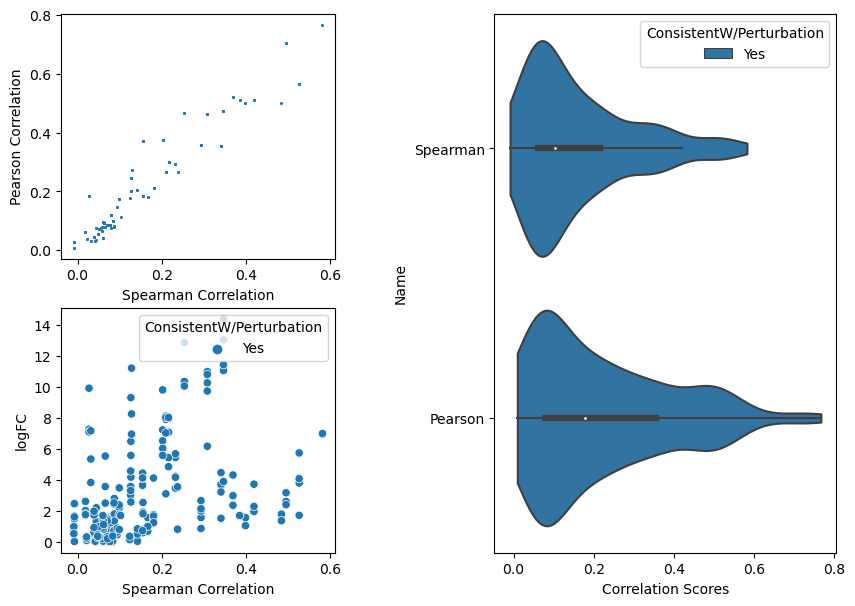

In [44]:
correlations = ingestion.computeCorrelation(pseudobulk_filtered, verbose=True)
pseudobulk_filtered.obs["spearmanCorr"] = correlations[0]
pseudobulk_filtered.obs[" pearsonCorr"] = correlations[1]

pseudobulk = pseudobulk_filtered.copy()

### Compute the Magnitude of Perturbation Effect

In [45]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv(humanTFPath, index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv(humanEpiPath, index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

### How big are the effects?

We compute several different measures to get a sense for the overall strength of each effect. They are all well correlated. 

In [46]:
""" If want to look at bigness on TF only """
TFVar = [i for i,p in enumerate(pseudobulk.var.index) if p in TFDict or p in EpiDict]
pseudobulkTFOnly = pseudobulk[:, TFVar].copy()
ingestion.quantifyEffect(adata=pseudobulkTFOnly, 
                         fname=perturbEffectTFOnlyPath, 
                         group=None, 
                         diffExprFC=False, 
                         prefix="TFOnly")

ingestion.quantifyEffect(adata=pseudobulk, 
                         fname=perturbEffectFullTranscriptomePath, 
                         group=None,
                         diffExprFC=False, 
                         prefix="")

listOfMetrics = ["DEG", "MI", "logFCMean", "logFCNorm2", "logFCMedian"]
for m in listOfMetrics:
    pseudobulk.obs[f"TFOnly{m}"] = pseudobulkTFOnly.obs[f"TFOnly{m}"]

195
0 AIRE 0.0 0.1278425753116607 0.0957219749689102 5.360742568969727 3.025809833206996
1 ASCL1 2.0 0.161111518740654 0.1212974041700363 7.5800862312316895 2.9390867856414165
2 ATF4 1.0 0.1117989048361778 0.0837588086724281 4.987577438354492 3.0066691331503
3 ATF5 0.0 0.1149908006191253 0.0841061249375343 5.835231781005859 2.9343334301879045
4 BACH2 0.0 0.0796282291412353 0.055919874459505 4.218928813934326 3.049102909773961
5 CCDC51 327.0 0.7125748991966248 0.5870983600616455 13.989238739013672 1.0327950246652795
6 CDKN1A 1.0 0.2208764106035232 0.1686841249465942 9.18039608001709 2.6057590251489016
7 CDKN1B 0.0 0.2277939319610595 0.1675810515880584 10.041678428649902 2.541512496368165
8 CEBPB 0.0 0.1711817234754562 0.125806838274002 7.7274298667907715 2.9367859481964924
9 CERKL 1.0 0.0971045047044754 0.0721485391259193 4.096304416656494 3.0344603048766468
10 COL2A1 0.0 0.1572818607091903 0.1161306649446487 6.595795631408691 2.778194150490834
11 COX5A 0.0 0.0785251483321189 0.05747584

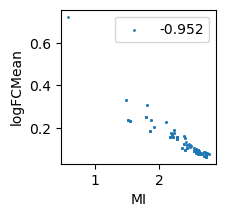

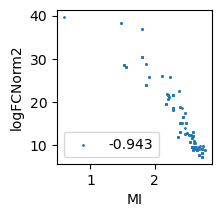

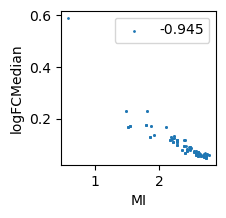

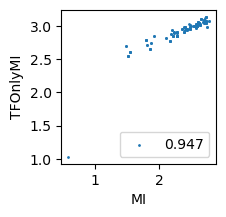

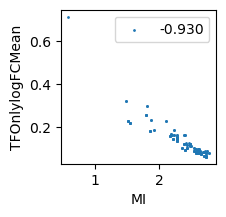

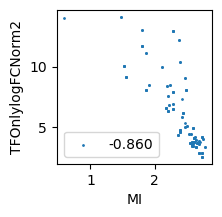

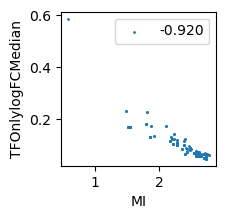

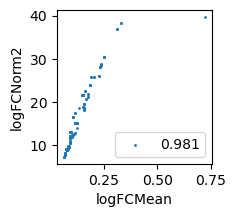

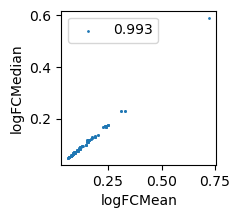

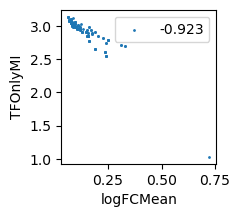

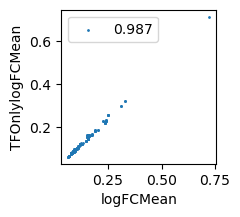

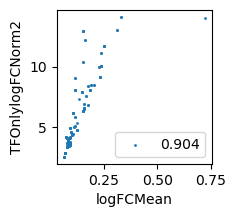

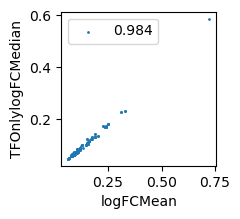

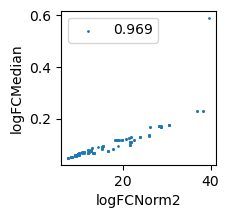

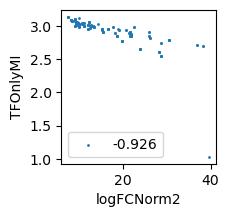

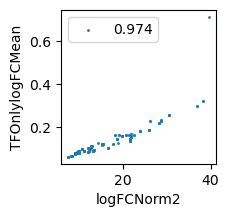

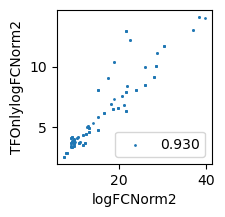

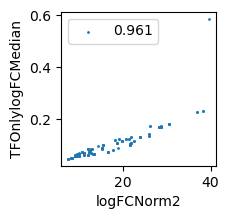

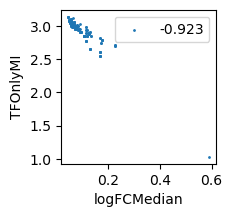

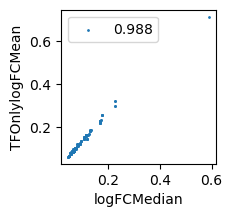

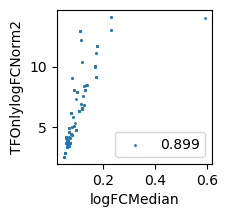

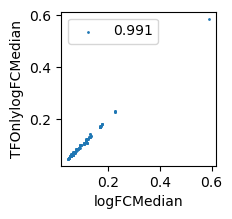

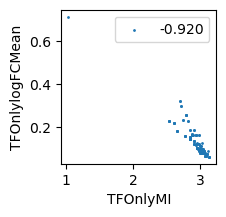

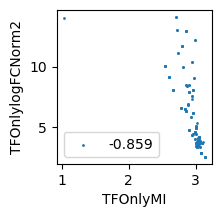

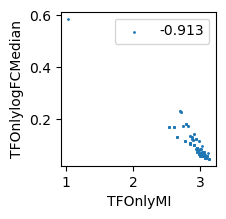

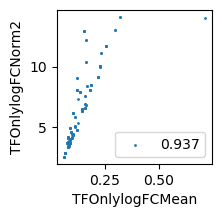

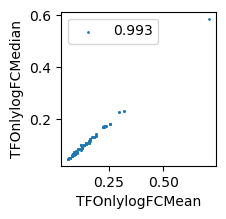

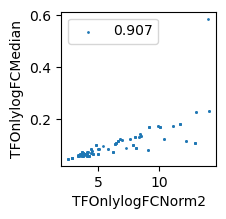

In [47]:
metricOfInterest = ["MI", "logFCMean", "logFCNorm2", "logFCMedian", 
                    "TFOnlyMI", "TFOnlylogFCMean", "TFOnlylogFCNorm2", "TFOnlylogFCMedian"]
ingestion.checkPerturbationEffectMetricCorrelation(pseudobulk, metrics=metricOfInterest)

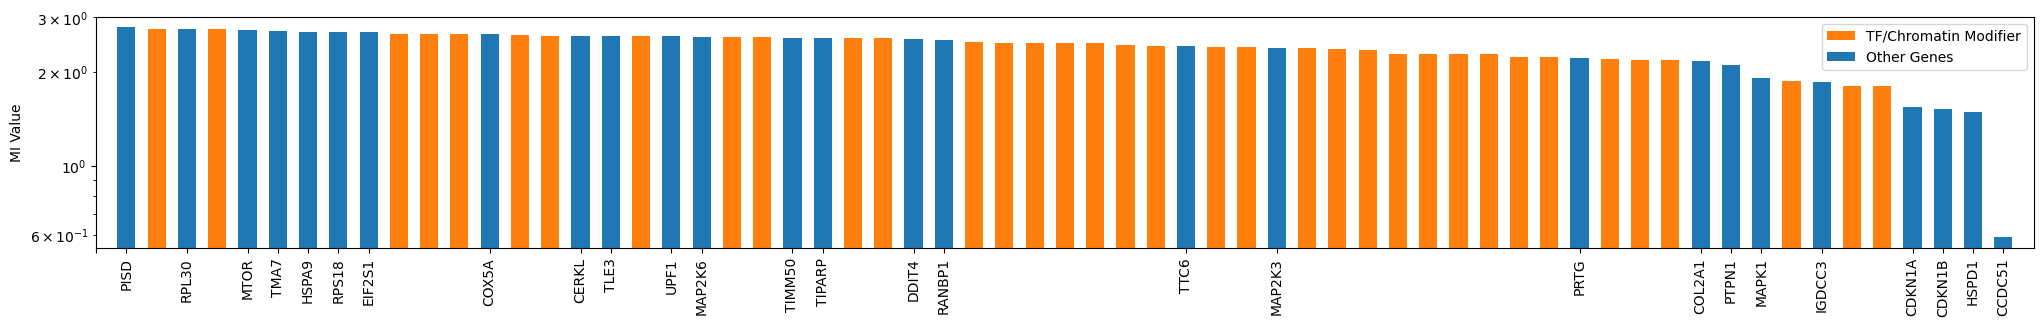

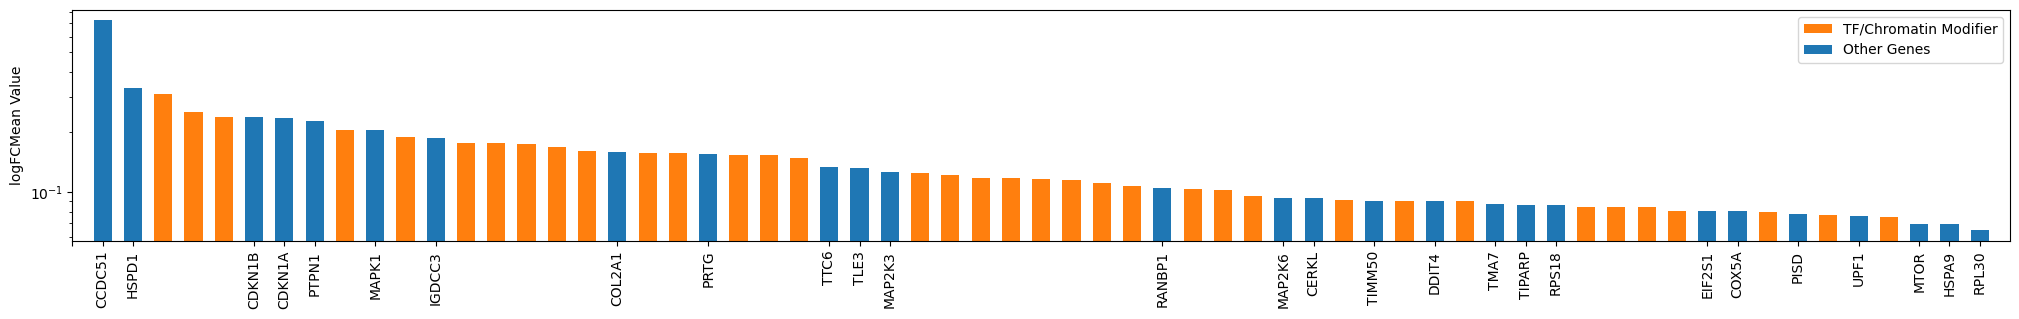

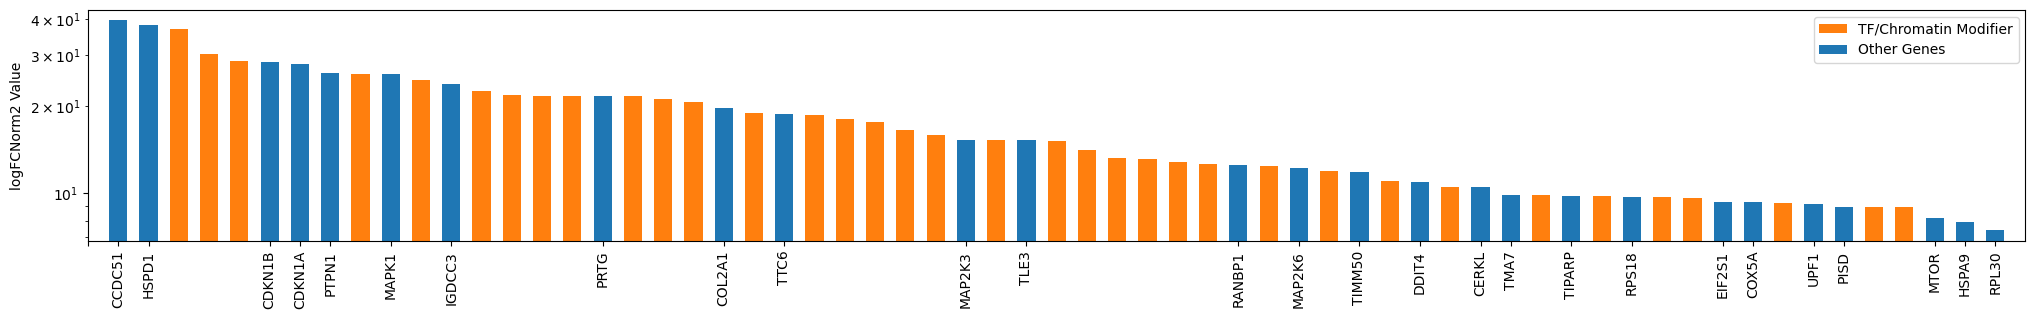

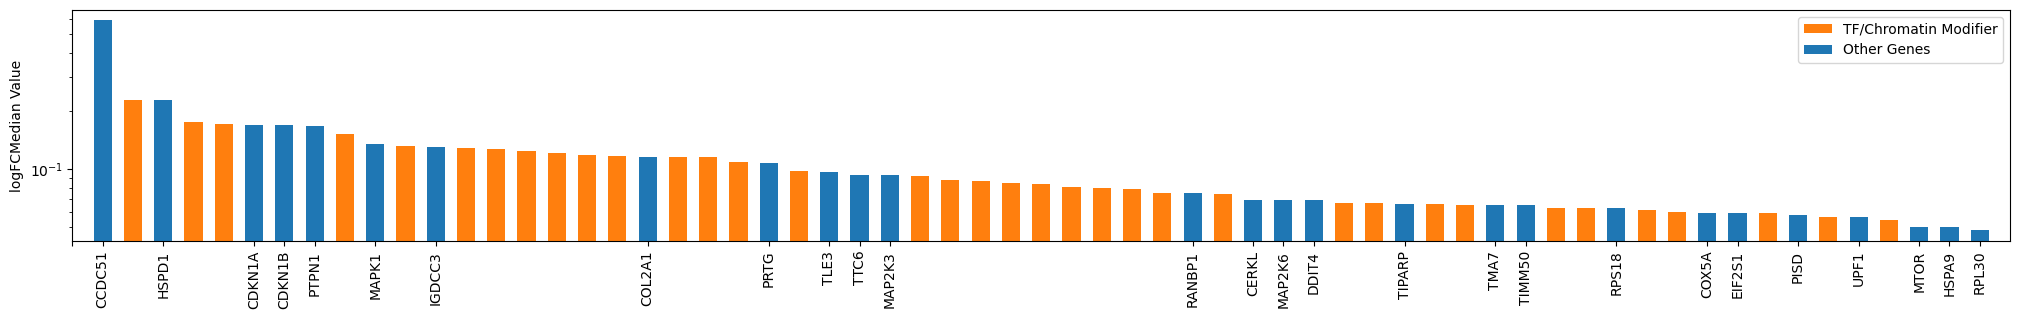

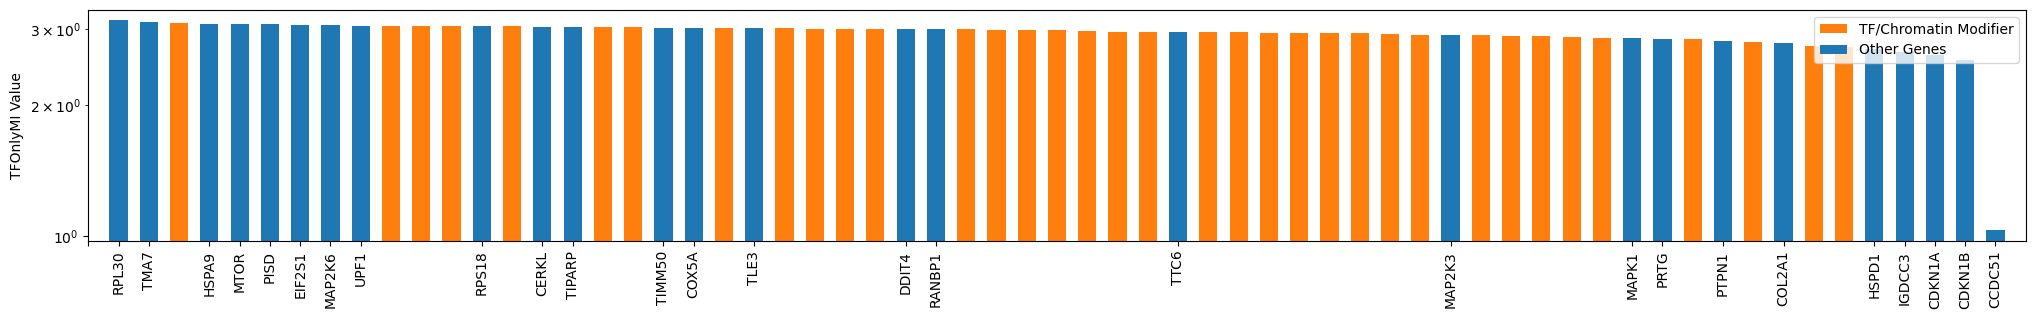

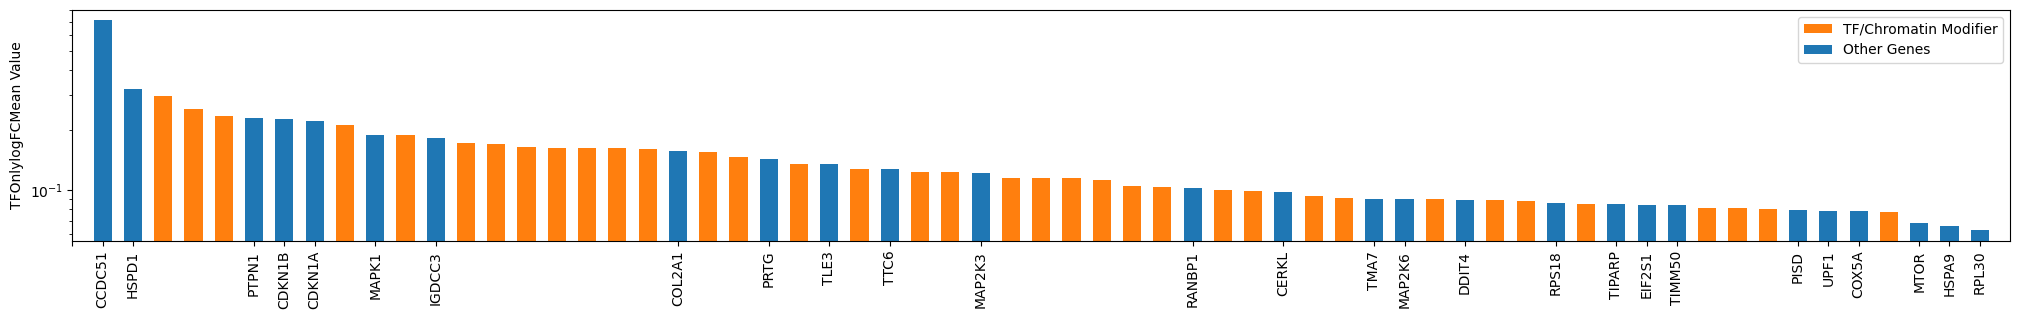

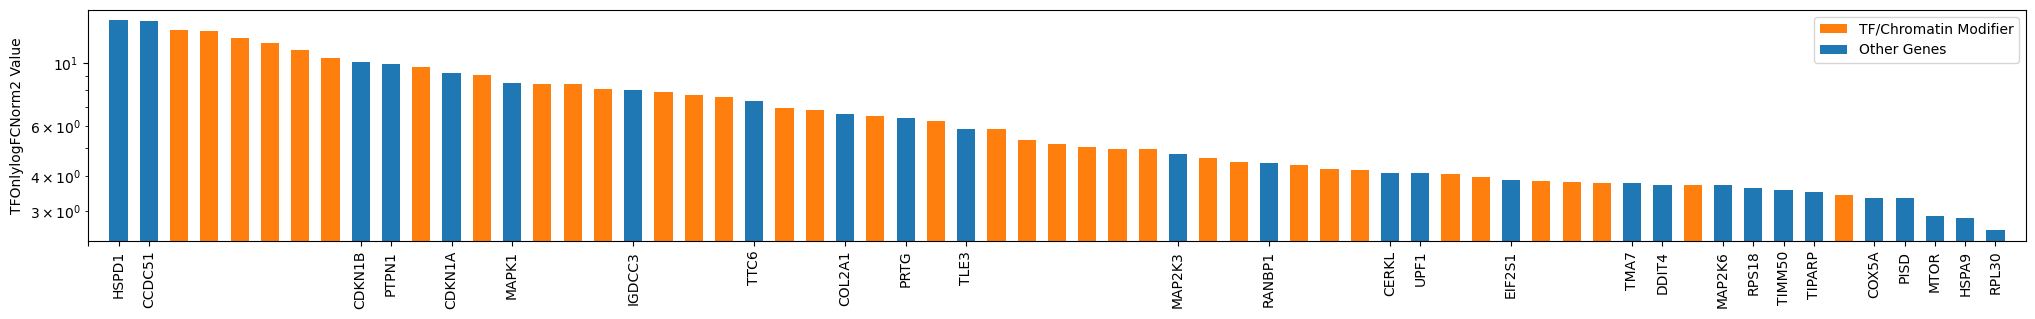

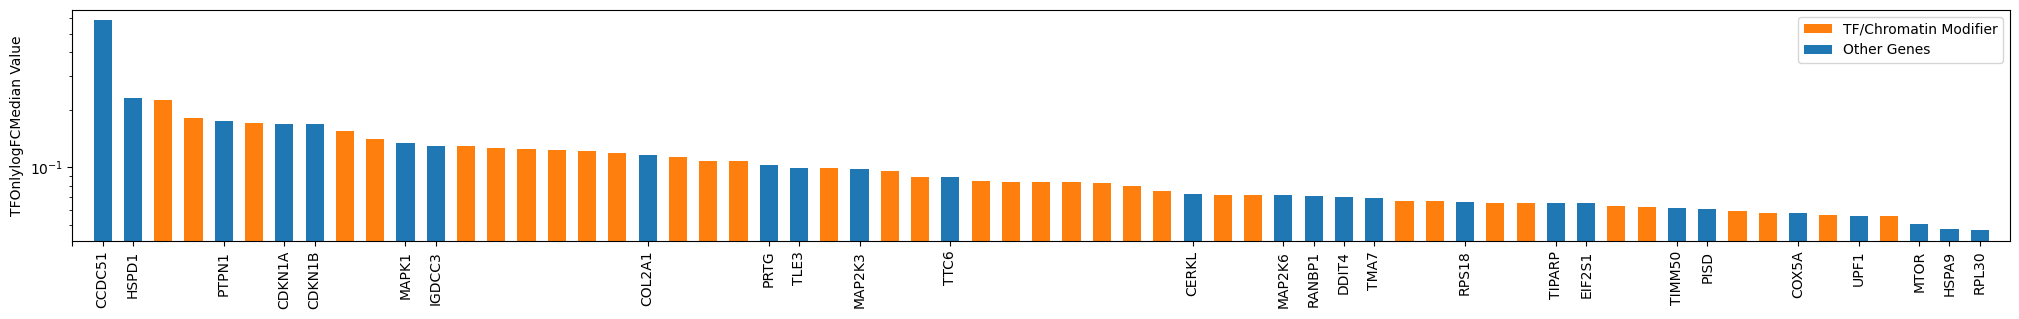

In [48]:
ingestion.visualizePerturbationEffect(pseudobulk, metrics=metricOfInterest, TFDict=TFDict, EpiDict=EpiDict)

In [49]:
sorted(set([(i,j) for i,j in pseudobulk.obs[['perturbation', 'logFCNorm2']].to_numpy()]), key=lambda x: x[1])

[('Non-Targeting', -999.0),
 ('RPL30', 7.402176856994629),
 ('HSPA9', 7.904314517974853),
 ('MTOR', 8.146395683288574),
 ('HIF1A', 8.892013549804688),
 ('CREB1', 8.896041870117188),
 ('PISD', 8.896894454956055),
 ('UPF1', 9.102328300476074),
 ('BACH2', 9.176976203918455),
 ('COX5A', 9.245381355285645),
 ('EIF2S1', 9.293620109558104),
 ('NRF1', 9.614249229431152),
 ('ZNF574', 9.626866340637209),
 ('RPS18', 9.634584426879885),
 ('ZNF236', 9.72487449645996),
 ('TIPARP', 9.736477851867676),
 ('FOXC1', 9.780800819396973),
 ('TMA7', 9.809751510620115),
 ('CERKL', 10.475381851196287),
 ('PPARGC1A', 10.494695663452148),
 ('DDIT4', 10.87732219696045),
 ('SREBF1', 11.02294635772705),
 ('TIMM50', 11.808576583862305),
 ('HSF1', 11.856918334960938),
 ('MAP2K6', 12.185993194580078),
 ('TFAP4', 12.381932258605955),
 ('RANBP1', 12.499125480651855),
 ('ATF4', 12.614702224731444),
 ('HIC2', 12.82667636871338),
 ('NPM1', 13.120346069335938),
 ('DDIT3', 13.177556037902832),
 ('AIRE', 14.071523666381836),


233 number of points are plotted


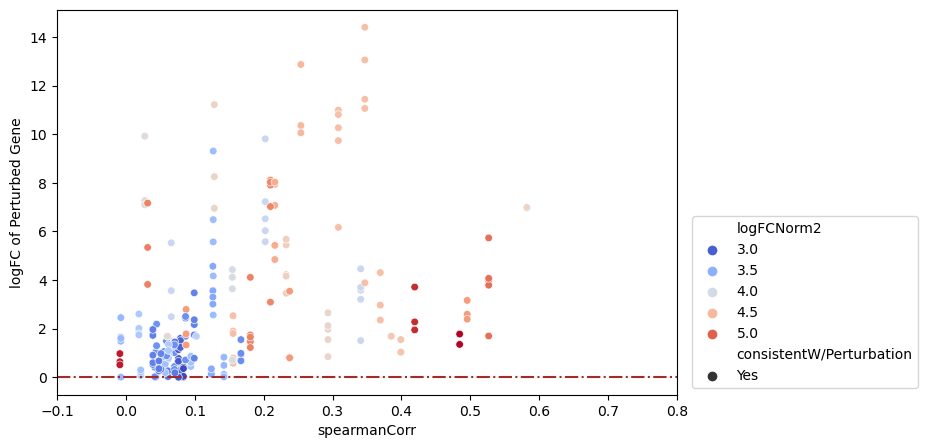

In [50]:
temp = pseudobulk.copy()

""" If wish to see more clearer, by masking the ones with 
much higher logFC norm2 values """
# temp = pseudobulk[(pseudobulk.obs.perturbation != 'CCDC51') 
#                   & (pseudobulk.obs.perturbation != 'HSPD1') 
#                   & (pseudobulk.obs.perturbation != 'SPI1') 
#                   & (pseudobulk.obs.perturbation != 'CEBPB')
#                  ].copy()

""" If you wish to see the magnitude of perturbation effect more clearer,
    i.e. a smoother gradient of the color shift, feel free to uncomment
    the line below, which takes the log of the norm2 """
temp.obs['logFCNorm2 (log-scale)'] = np.log2(temp.obs['logFCNorm2'])

ingestion.visualizePerturbationMetadata(temp, 
                                        x="spearmanCorr", 
                                        y="logFC", 
                                        style="consistentW/Perturbation", 
                                        hue="logFCNorm2 (log-scale)", 
                                        markers=['o', '^'], 
                                        xlim=[-0.1, 0.8])

### Basic EDA

What does the final, fully filtered set of pseudo-bulk profiles look like?

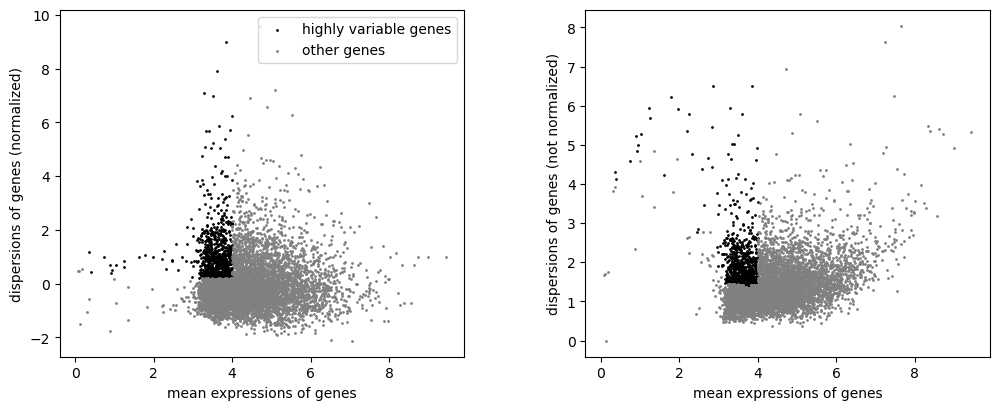

In [55]:
sc.pp.log1p(pseudobulk)
sc.pp.highly_variable_genes(pseudobulk, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(pseudobulk)
with warnings.catch_warnings():
    sc.tl.pca(pseudobulk, n_comps=100)
sc.pp.neighbors(pseudobulk)
sc.tl.umap(pseudobulk)
clusterResolutions = []
sc.tl.leiden(pseudobulk)
cc_genes = pd.read_csv(cellcycleGenePath, header = None)[0]
sc.tl.score_genes_cell_cycle(pseudobulk, s_genes=cc_genes[:43], g2m_genes=cc_genes[43:])

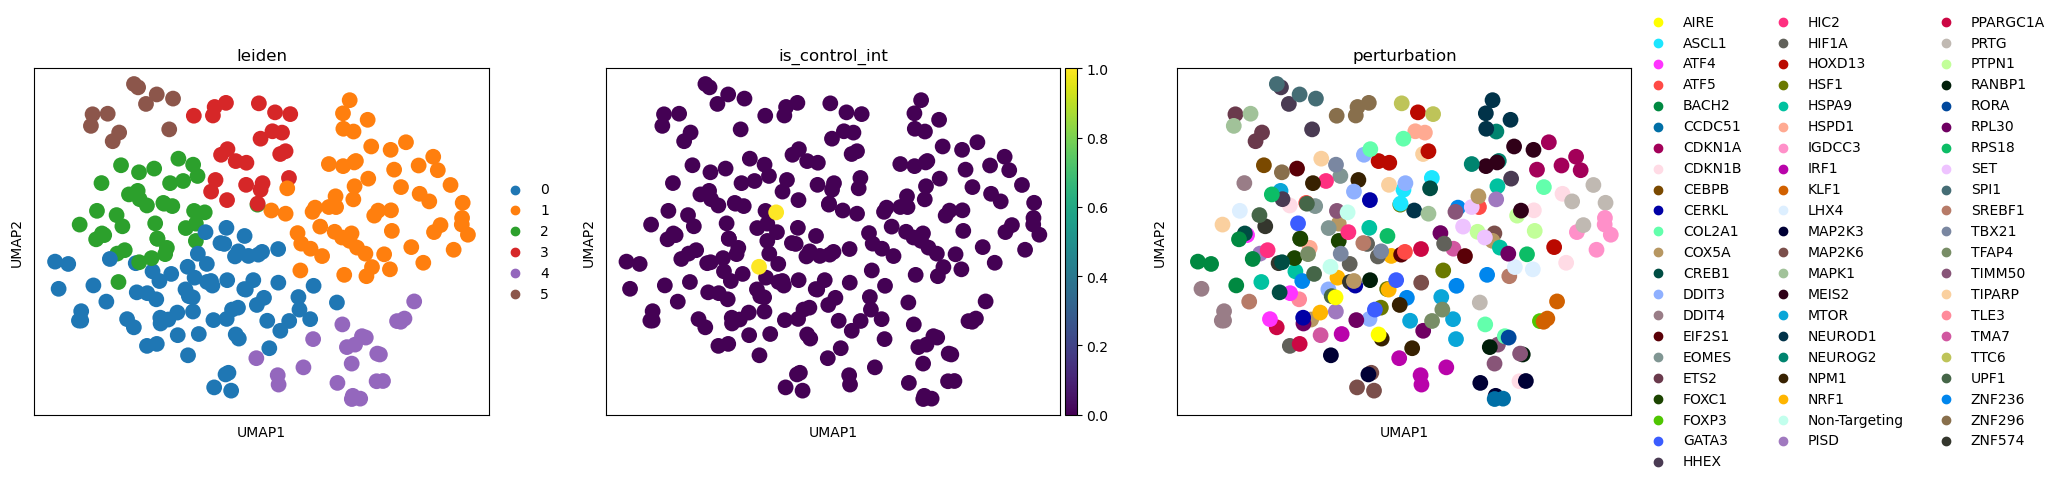

In [59]:
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(pseudobulk, color = [
    # "PTPRC",
    "leiden", 
    "is_control_int",
    "perturbation",
])
# Will ask CO to use only one cluster.
# This requires setting certain other undocumented aspects of object state. :(
pseudobulk.obs["fake_cluster"]="all_one_cluster"
pseudobulk.obs.fake_cluster = pseudobulk.obs.fake_cluster.astype("category")
pseudobulk.uns["fake_cluster_colors"] = ['#1f77b4']

In [60]:
pseudobulk

AnnData object with n_obs × n_vars = 233 × 6651
    obs: 'is_control', 'is_control_int', 'perturbation', 'guideRNA', 'consistentW/Perturbation', 'logFC', 'spearmanCorr', ' pearsonCorr', 'DEG', 'MI', 'logFCMean', 'logFCNorm2', 'logFCMedian', 'TFOnlyDEG', 'TFOnlyMI', 'TFOnlylogFCMean', 'TFOnlylogFCNorm2', 'TFOnlylogFCMedian', 'leiden', 'S_score', 'G2M_score', 'phase', 'fake_cluster'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'perturbation_colors', 'fake_cluster_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [61]:
perturbed_genes = set(list(pseudobulk.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(pseudobulk.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(pseudobulk.var.index)
genes_keep = pseudobulk.var.index[pseudobulk.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
print("These genes were perturbed:")
print(perturbed_genes)
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

These genes were perturbed:
{'IGDCC3', 'TTC6', 'NPM1', 'RANBP1', 'DDIT4', 'EIF2S1', 'ATF5', 'GATA3', 'AIRE', 'EOMES', 'CDKN1A', 'TMA7', 'HHEX', 'KLF1', 'BACH2', 'MTOR', 'CERKL', 'CCDC51', 'FOXC1', 'MEIS2', 'TFAP4', 'TIMM50', 'PISD', 'TLE3', 'LHX4', 'HSPD1', 'MAP2K3', 'CDKN1B', 'ZNF296', 'CEBPB', 'IRF1', 'CREB1', 'SREBF1', 'MAP2K6', 'ASCL1', 'UPF1', 'DDIT3', 'PPARGC1A', 'RPL30', 'MAPK1', 'NEUROD1', 'RPS18', 'ZNF236', 'COL2A1', 'PTPN1', 'HIC2', 'HOXD13', 'ETS2', 'RORA', 'NEUROG2', 'NRF1', 'FOXP3', 'TBX21', 'PRTG', 'ATF4', 'ZNF574', 'COX5A', 'HIF1A', 'SET', 'TIPARP', 'SPI1', 'HSF1', 'HSPA9'}
These genes were perturbed but not measured:
{'CERKL', 'PPARGC1A'}
This many variable genes will be kept and used by CO:
800


In [62]:
# final form, ready to save
pseudobulk.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
pseudobulk.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
pseudobulk = ingestion.describe_perturbation_effect(pseudobulk, "overexpression")

In [63]:
os.makedirs(f"perturbations/{dataset_name}", exist_ok = True)
pseudobulk.write_h5ad(f"perturbations/{dataset_name}/test.h5ad")